## <font color='darkblue'>Preface</font>
([article source](https://machinelearningmastery.com/dynamic-classifier-selection-in-python/)) **<font size='3ptx'>Dynamic classifier selection is a type of ensemble learning algorithm for classification predictive modeling.</font>**

The technique involves fitting multiple machine learning models on the training dataset, then selecting the model that is expected to perform best when making a prediction, based on the specific details of the example to be predicted.

This can be achieved using a k-nearest neighbor model to locate examples in the training dataset that are closest to the new example to be predicted, **evaluating all models in the pool on this neighborhood and using the model that performs the best on the neighborhood to make a prediction for the new example.**

As such, **the dynamic classifier selection can often perform better than any single model in the pool and provides an alternative to averaging the predictions from multiple models, as is the case in other ensemble algorithms.**

In this tutorial, you will discover how to develop dynamic classifier selection ensembles in Python. After completing this tutorial, you will know:
* Dynamic classifier selection algorithms choose one from among many models to make a prediction for each new example.
* How to develop and evaluate dynamic classifier selection models for classification tasks using the scikit-learn API.
* How to explore the effect of dynamic classifier selection model hyperparameters on classification accuracy.

### <font color='darkgreen'>Tutorial Overview</font>
This tutorial is divided into three parts; they are:
* <font size='3ptx'>[**Dynamic Classifier Selection**](#sect1)</font>
* <font size='3ptx'>[**Dynamic Classifier Selection With Scikit-Learn**](#sect2)</font>
    * [**DCS With Overall Local Accuracy (OLA)**](#sect2_1)
    * [**DCS With Local Class Accuracy (LCA)**](#sect2_2)
* <font size='3ptx'>[**Hyperparameter Tuning for DCS**](#sect3)</font>
    * [**Explore k in k-Nearest Neighbor**](#sect3_1)
    * [**Explore Algorithms for Classifier Pool**](#sect3_2)

In [1]:
from sklearn.datasets import make_classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from deslib.dcs.ola import OLA
from deslib.dcs.lca import LCA
from matplotlib import pyplot
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

<a id='sect1'></a>
## <font color='darkblue'>Dynamic Classifier Selection</font>
**Multiple Classifier Systems** refers to a field of machine learning algorithms that use multiple models to address classification predictive modeling problems. This includes familiar techniques such as [one-vs-rest, one-vs-all](https://machinelearningmastery.com/one-vs-rest-and-one-vs-one-for-multi-class-classification/), and output error-correcting codes techniques. It also includes more general techniques that select a model to use dynamically for each new example that requires a prediction.
> Several approaches are currently used to construct an MCS. One of the most promising MCS approaches is Dynamic Selection (DS), in which the base classifiers are selected on the fly, according to each new sample to be classified. <br/><br/>
> [**— Dynamic Classifier Selection: Recent Advances And Perspectives, 2018.**](https://www.sciencedirect.com/science/article/pii/S1566253517304074)

For more on these types of multiple classifier systems, see the tutorial:
* [How to Use One-vs-Rest and One-vs-One for Multi-Class Classification](https://machinelearningmastery.com/one-vs-rest-and-one-vs-one-for-multi-class-classification/)

These methods are generally known by the name: **<font color='darkblue'>Dynamic Classifier Selection</font>**, or DCS for short.
> **Dynamic Classifier Selection:** Algorithms that choose one from among many trained models to make a prediction based on the specific details of the input.

Given that multiple models are used in DCS, **it is considered a type of ensemble learning technique.**

**Dynamic Classifier Selection algorithms generally involve partitioning the input feature space in some way and assigning specific models to be responsible for making predictions for each partition.** There are a variety of different DCS algorithms and research efforts are mainly focused on how to evaluate and assign classifiers to specific regions of the input space.
> After training multiple individual learners, DCS dynamically selects one learner for each test instance. DCS makes predictions by using one individual learner. <br/><br/>
> [**— Page 93, Ensemble Methods: Foundations and Algorithms, 2012.**](https://amzn.to/32L1yWD)

An early and popular approach involves first fitting a small, diverse set of classification models on the training dataset. When a prediction is required, first a [**K-nearest neighbor**](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) (kNN) algorithm is used to find the `k` most similar examples from the training dataset that match the example. **Each previously fit classifier in the model is then evaluated on the neighbor of k training examples and the classifier that performs the best is selected to make a prediction for the new example.**

This approach is referred to as “Dynamic Classifier Selection Local Accuracy” or DCS-LA for short and was described by Kevin Woods, et al. in their 1997 paper titled “[Combination Of Multiple Classifiers Using Local Accuracy Estimates.](https://ieeexplore.ieee.org/abstract/document/588027)”
> The basic idea is to estimate each classifier’s accuracy in local region of feature space surrounding an unknown test sample, and then use the decision of the most locally accurate classifier.

The authors describe two approaches for selecting a single classifier model to make a prediction for a given input example, they are:
* **Local Accuracy**, often referred to as LA or Overall Local Accuracy (OLA).
* **Class Accuracy**, often referred to as CA or Local Class Accuracy (LCA).

**<font color='darkblue'>Local Accuracy</font>** (OLA) involves evaluating the classification accuracy of each model on the neighborhood of `k` training examples. The model that performs the best in this neighborhood is then selected to make a prediction for the new example.
> The OLA of each classifier is computed as the percentage of the correct recognition of the samples in the local region. <br/><br/>
> [**— Dynamic Selection Of Classifiers—a Comprehensive Review, 2014.**](https://www.sciencedirect.com/science/article/abs/pii/S0031320314001885)

**<font color='darkblue'>Class Accuracy</font>** (LCA) involves using each model to make a prediction for the new example and noting the class that was predicted. Then, the accuracy of each model on the neighbor of `k` training examples is evaluated and the model that has the best skill for the class that it predicted on the new example is selected and its prediction returned.
> The LCA is estimated for each base classifier as the percentage of correct classifications within the local region, but considering only those examples where the classifier has given the same class as the one it gives for the unknown pattern. <br/><br/>
> [**— Dynamic Selection Of Classifiers—a Comprehensive Review, 2014.**](https://www.sciencedirect.com/science/article/abs/pii/S0031320314001885)

In both cases, if all fit models make the same prediction for a new input example, then the prediction is returned directly. Now that we are familiar with DCS and the DCS-LA algorithm, let’s look at how we can use it on our own classification predictive modeling projects.

<a id='sect2'></a>
## <font color='darkblue'>Dynamic Classifier Selection With Scikit-Learn</font>
[**The Dynamic Ensemble Selection Library**](https://github.com/scikit-learn-contrib/DESlib) or DESlib for short is an open source Python library that provides an implementation of many different dynamic classifier selection algorithms. DESlib is an easy-to-use ensemble learning library **focused on the implementation of the state-of-the-art techniques for dynamic classifier and ensemble selection.**

First, we can install the DESlib library using the pip package manager.

In [2]:
# !pip install deslib

Once installed, we can confirm that the library was installed correctly and is ready to be used by loading the library and printing the installed version.

In [3]:
# check deslib version
import deslib
print(deslib.__version__)

0.3.5


The DESlib provides an implementation of the DCS-LA algorithm with each classifier selection technique via the [**OLA**](https://deslib.readthedocs.io/en/latest/modules/dcs/ola.html) and [**LCA**](https://deslib.readthedocs.io/en/latest/modules/dcs/lca.html) classes respectively.

Each class can be used as a scikit-learn model directly, allowing the full suite of scikit-learn data preparation, modeling pipelines, and model evaluation techniques to be used directly.

Both classes use a k-nearest neighbor algorithm to select the neighbor with a default value of `k=7`.

A [**bootstrap aggregation**](https://machinelearningmastery.com/bagging-ensemble-with-python/) (<font color='brown'>bagging</font>) ensemble of decision trees is used as the pool of classifier models considered for each classification that is made by default, although this can be changed by setting “<font color='violet'>pool_classifiers</font>” to a list of models.

We can use the [make_classification()](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) function to create a synthetic binary classification problem with 10,000 examples and 20 input features.

In [4]:
# define dataset
X, y = make_classification(n_samples=10000, n_features=20, n_informative=15, n_redundant=5, random_state=7)
# summarize the dataset
print(X.shape, y.shape)

(10000, 20) (10000,)


<a id='sect2_1'></a>
### <font color='darkgreen'>DCS With Overall Local Accuracy (OLA)</font>
**We can evaluate a DCS-LA model using overall local accuracy on the synthetic dataset.**

In this case, we will use default model hyperparameters, including bagged decision trees as the pool of classifier models and a `k=7` for the selection of the local neighborhood when making a prediction.

We will evaluate the model using repeated stratified k-fold cross-validation with three repeats and 10 folds. We will report the mean and standard deviation of the accuracy of the model across all repeats and folds.

In [5]:
# define dataset
X, y = make_classification(n_samples=10000, n_features=20, n_informative=15, n_redundant=5, random_state=7)

# define the model
model = OLA()

# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# evaluate the model
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

In [6]:
# report performance
print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Mean Accuracy: 0.883 (0.011)


In this case, we can see the DCS-LA with OLA and default hyperparameters achieves a classification accuracy of about 88.3 percent.

We can also use the DCS-LA model with OLA as a final model and make predictions for classification. First, the model is fit on all available data, then the predict() function can be called to make predictions on new data.

In [7]:
# define dataset
X, y = make_classification(n_samples=10000, n_features=20, n_informative=15, n_redundant=5, random_state=7)

# define the model
model = OLA()

# fit the model on the whole dataset
model.fit(X, y)

OLA(DFP=False, DSEL_perc=0.5, IH_rate=0.3, diff_thresh=0.1, k=7,
    knn_classifier='knn', knne=False, n_jobs=-1, pool_classifiers=None,
    random_state=None, safe_k=None, selection_method='best', with_IH=False)

In [8]:
# make a single prediction
row = [0.2929949,-4.21223056,-1.288332,-2.17849815,-0.64527665,2.58097719,0.28422388,-7.1827928,-1.91211104,2.73729512,0.81395695,3.96973717,-2.66939799,3.34692332,4.19791821,0.99990998,-0.30201875,-4.43170633,-2.82646737,0.44916808]
yhat = model.predict([row])
print('Predicted Class: %d' % yhat[0])

Predicted Class: 0


Now that we are familiar with using DCS-LA with OLA, let’s look at the LCA method.

<a id='sect2_2'></a>
### <font color='darkgreen'>DCS With Local Class Accuracy (LCA)</font>
**We can evaluate a DCS-LA model using local class accuracy on the synthetic dataset.**

In this case, we will use default model hyperparameters, including bagged decision trees as the pool of classifier models and a `k=7` for the selection of the local neighborhood when making a prediction.

We will evaluate the model using repeated stratified k-fold cross-validation with three repeats and 10 folds. We will report the mean and standard deviation of the accuracy of the model across all repeats and folds.

In [9]:
# define dataset
X, y = make_classification(n_samples=10000, n_features=20, n_informative=15, n_redundant=5, random_state=7)

# define the model
model = LCA()

# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# evaluate the model
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance
print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Mean Accuracy: 0.920 (0.009)


In this case, we can see the DCS-LA with LCA and default hyperparameters achieves a classification accuracy of about 92.2 percent.

We can also use the DCS-LA model with LCA as a final model and make predictions for classification. First, the model is fit on all available data, then the <font color='blue'>predict()</font> function can be called to make predictions on new data.

In [10]:
# define dataset
X, y = make_classification(n_samples=10000, n_features=20, n_informative=15, n_redundant=5, random_state=7)

# define the model
model = LCA()

# fit the model on the whole dataset
model.fit(X, y)

# make a single prediction
row = [0.2929949,-4.21223056,-1.288332,-2.17849815,-0.64527665,2.58097719,0.28422388,-7.1827928,-1.91211104,2.73729512,0.81395695,3.96973717,-2.66939799,3.34692332,4.19791821,0.99990998,-0.30201875,-4.43170633,-2.82646737,0.44916808]
yhat = model.predict([row])
print('Predicted Class: %d' % yhat[0])

Predicted Class: 1


<a id='sect3'></a>
## <font color='darkblue'>Hyperparameter Tuning for DCS</font>
**In this section, we will take a closer look at some of the hyperparameters you should consider tuning for the DCS-LA model and their effect on model performance.**

There are many hyperparameters we can look at for DCS-LA, **although in this case, we will look at the value of `k` in the k-nearest neighbor model used in the local evaluation of the models, and how to use a custom pool of classifiers.**

We will use the DCS-LA with OLA as the basis for these experiments, although the choice of the specific method is arbitrary.

<a id='sect3_1'></a>
### <font color='darkgreen'>Explore k in k-Nearest Neighbor</font>
**The configuration of the k-nearest neighbor algorithm is critical to the DCS-LA model** as it defines the scope of the neighborhood in which each classifier is considered for selection.

**The `k` value controls the size of the neighborhood and it is important to set it to a value that is appropriate for your dataset, specifically the density of samples in the feature space.** A value too small will mean that relevant examples in the training set might be excluded from the neighborhood, whereas values too large may mean that the signal is being washed out by too many examples.

The example below explores the classification accuracy of the DCS-LA with OLA with k values from 2 to 21.

In [11]:
# get the dataset
def get_dataset():
    X, y = make_classification(n_samples=10000, n_features=20, n_informative=15, n_redundant=5, random_state=7)
    return X, y
 
# get a list of models to evaluate
def get_models():
    models = dict()
    for n in range(2,22):
        models[str(n)] = OLA(k=n)
    return models
 
# evaluate a give model using cross-validation
def evaluate_model(model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores
 
# define dataset
X, y = get_dataset()

# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

>2 0.871 (0.009)
>3 0.874 (0.010)
>4 0.876 (0.012)
>5 0.879 (0.011)
>6 0.878 (0.011)
>7 0.882 (0.009)
>8 0.885 (0.013)
>9 0.883 (0.010)
>10 0.886 (0.011)
>11 0.888 (0.009)
>12 0.887 (0.009)
>13 0.887 (0.010)
>14 0.887 (0.009)
>15 0.889 (0.008)
>16 0.891 (0.011)
>17 0.890 (0.009)
>18 0.889 (0.010)
>19 0.890 (0.011)
>20 0.887 (0.010)
>21 0.887 (0.011)


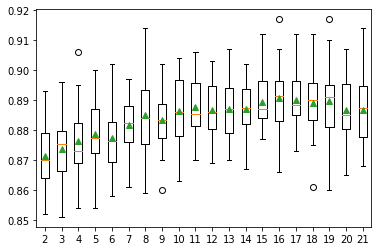

In [12]:
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

We can see the general trend of increasing model performance and `k value` before reaching a plateau.

<a id='sect3_2'></a>
### <font color='darkgreen'>Explore Algorithms for Classifier Pool</font>
**The choice of algorithms used in the pool for the DCS-LA is another important hyperparameter.**

By default, bagged decision trees are used, as it has proven to be an effective approach on a range of classification tasks. Nevertheless, a custom pool of classifiers can be considered.

This requires first defining a list of classifier models to use and fitting each on the training dataset. Unfortunately, this means that the automatic k-fold cross-validation model evaluation methods in scikit-learn cannot be used in this case. Instead, we will use a train-test split so that we can fit the classifier pool manually on the training dataset.

The list of fit classifiers can then be specified to the OLA (or LCA) class via the “<font color='violet'>pool_classifiers</font>” argument. In this case, we will use a pool that includes logistic regression, a decision tree, and a naive Bayes classifier.

In [13]:
X, y = make_classification(n_samples=10000, n_features=20, n_informative=15, n_redundant=5, random_state=7)

# split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# define classifiers to use in the pool
classifiers = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    GaussianNB()
]

# fit each classifier on the training set
for c in classifiers:
    c.fit(X_train, y_train)

# define the DCS-LA model
model = OLA(pool_classifiers=classifiers)

# fit the model
model.fit(X_train, y_train)

# make predictions on the test set
yhat = model.predict(X_test)

# evaluate predictions
score = accuracy_score(y_test, yhat)
print('Accuracy: %.3f' % (score))

Accuracy: 0.915


In this case, we can see that the model achieved an accuracy of about 91.2 percent.

**In order to adopt the DCS model, it must perform better than any contributing model**. Otherwise, we would simply use the contributing model that performs better instead.

We can check this by evaluating the performance of each contributing classifier on the test set.

In [14]:
# evaluate contributing models
for c in classifiers:
    yhat = c.predict(X_test)
    score = accuracy_score(y_test, yhat)
    print('>%s: %.3f' % (c.__class__.__name__, score))

>LogisticRegression: 0.873
>DecisionTreeClassifier: 0.886
>GaussianNB: 0.875


In this case, we can see that again, the DCS-LA achieves an accuracy of about 91.3 percent, which is better than any contributing model.

## <font color='darkblue'>Ensembling Comparison</font>

Here we use Keras to train a ensembling model for comparison: